In [1]:
# !pip install tensorflow>=2.2.0
# !pip install tensorflow_probability

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline

tf.__version__

'2.1.0'

# Demo of Denoising Autoencoders

In [131]:
# use mnist as example
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()


def preprocess_image(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return images.astype('float32')


def add_noise(images, noise_scale=0.5):
    return images + noise_scale * np.random.normal(loc=0.0, scale=0.1, size=images.shape)

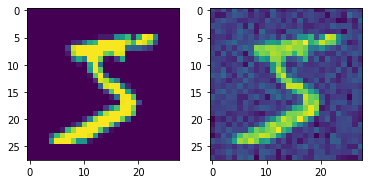

In [135]:
# 在原数据上加噪声的效果
sample_image = preprocess_image(train_images[[0]])[0]
noise_image = add_noise(sample_image, noise_scale=1.0)

_, axes = plt.subplots(1, 2)
axes[0].imshow(sample_image.squeeze())
axes[1].imshow(noise_image.squeeze())

In [136]:
# prepare dataset
train_size = 60000
batch_size = 64
test_size = 10000

train_images = preprocess_image(train_images)
test_images = preprocess_image(test_images)

def construct_pair(img, noise_scale=1.0):
    return (add_noise(img, 1.0), img)

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).map(construct_pair)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).map(construct_pair)
                .shuffle(test_size).batch(batch_size))

In [137]:
# define model 
from tensorflow.keras import layers
from tensorflow import keras


class DenoisingAutoencoder(keras.models.Model):
    
    def __init__(self, latent_dim=32, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        
        self.encoder = keras.models.Sequential([
            layers.InputLayer(input_shape=(28, 28, 1)),
            layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'), # 28 * 28 * 8
            layers.MaxPool2D(pool_size=(2, 2), padding='same'), # 14 * 14 * 8
            layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'), # 14 * 14 * 8
            layers.MaxPool2D(pool_size=(2, 2), padding='same'), # 7 * 7 * 8
            layers.Flatten(),
            layers.Dense(latent_dim, activity_regularizer=keras.regularizers.l1(1e-5)) # 添加l1正则项来让隐含层更稀疏            
        ], name='encoder')
        
        self.decoder = keras.models.Sequential([
            layers.InputLayer(input_shape=(latent_dim)),
            layers.Dense(392),
            layers.Reshape((7, 7, 8)),
            layers.Conv2DTranspose(8, kernel_size=(3, 3), strides=(2, 2), padding='same'), # 14 * 14 * 8
            layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'), # 14 * 14 * 8
            layers.Conv2DTranspose(8, kernel_size=(3, 3), strides=(2, 2), padding='same'), # 28 * 28 * 8
            layers.Conv2D(1, kernel_size=(3, 3), padding='same', activation='relu'), # 28 * 28 * 1
        ], name='decoder')
    
    def encode(self, image):
        return self.encoder(image)
    
    def decode(self, image):
        return self.decoder(image)
        
    def call(self, image):
        latent = self.encode(image)
        return self.decode(latent)

In [138]:
model = DenoisingAutoencoder(latent_dim=64)
model.compile(optimizer='adam', loss='mse')

In [139]:
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Train for 938 steps, validate for 157 steps
Epoch 1/5
938/938 [==============================] - 31s 33ms/step - loss: 0.0203 - val_loss: 0.0108
Epoch 2/5
938/938 [==============================] - 31s 34ms/step - loss: 0.0084 - val_loss: 0.0089
Epoch 3/5
938/938 [==============================] - 36s 38ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 4/5
938/938 [==============================] - 33s 35ms/step - loss: 0.0064 - val_loss: 0.0076
Epoch 5/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0059 - val_loss: 0.0072


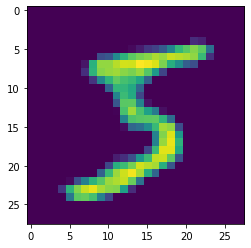

In [141]:
def denoise(model, image):
    # denoise a single image
    denoised = model(image[np.newaxis, ...]).numpy().squeeze()
    return denoised


plt.imshow(denoise(model, noise_image))

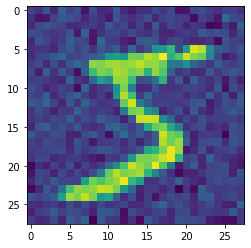

In [142]:
plt.imshow(noise_image.squeeze())

# Demo of VAE on MNIST

In [2]:
train_size = 60000
batch_size = 32
test_size = 10000

In [3]:
# use mnist as example
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()


def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

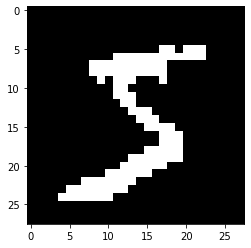

In [4]:
plt.imshow(train_images[0].squeeze(), cmap='gray')

In [15]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


class VAE(tf.keras.Model):

    def __init__(self, latent_dim, opt=None):
        super().__init__()
        self.latent_dim = latent_dim
        self.opt = opt or tf.keras.optimizers.Adam(1e-4)
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )
        
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def decode(self, z):
        logits = self.decoder(z)
        return logits
#         return tf.sigmoid(logits)
    
    @tf.function
    def sample(self, n=100, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(n, self.latent_dim))
        return self.decode(eps)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    @tf.function
    def compute_loss(self, x):
        mean, logvar = self.encode(x)
        z = model.reparameterize(mean, logvar)
        x_logit = self.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    
    @tf.function
    def train(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return loss

In [16]:
model = VAE(latent_dim=3)

In [17]:
epochs = 10

for e in range(epochs):
    for i, x in enumerate(train_dataset):
        loss = model.train(x)
        if i % 100 == 0:
            print(f'Epoch {e}, Step {i}, Loss: {loss}')

Epoch 0, Step 0, Loss: 542.686767578125
Epoch 0, Step 100, Loss: 407.926513671875
Epoch 0, Step 200, Loss: 264.59503173828125
Epoch 0, Step 300, Loss: 219.7979736328125
Epoch 0, Step 400, Loss: 210.24435424804688
Epoch 0, Step 500, Loss: 201.87814331054688
Epoch 0, Step 600, Loss: 207.2767333984375
Epoch 0, Step 700, Loss: 202.0150604248047
Epoch 0, Step 800, Loss: 203.4485321044922
Epoch 0, Step 900, Loss: 196.92193603515625
Epoch 0, Step 1000, Loss: 194.33486938476562
Epoch 0, Step 1100, Loss: 187.56553649902344
Epoch 0, Step 1200, Loss: 176.79830932617188
Epoch 0, Step 1300, Loss: 171.27064514160156
Epoch 0, Step 1400, Loss: 183.76953125
Epoch 0, Step 1500, Loss: 175.10414123535156
Epoch 0, Step 1600, Loss: 176.72967529296875
Epoch 0, Step 1700, Loss: 167.51351928710938
Epoch 0, Step 1800, Loss: 173.41702270507812
Epoch 1, Step 0, Loss: 186.98016357421875
Epoch 1, Step 100, Loss: 164.63099670410156
Epoch 1, Step 200, Loss: 159.73471069335938
Epoch 1, Step 300, Loss: 153.122589111328

Epoch 9, Step 1600, Loss: 114.23011779785156
Epoch 9, Step 1700, Loss: 149.72698974609375
Epoch 9, Step 1800, Loss: 138.80377197265625


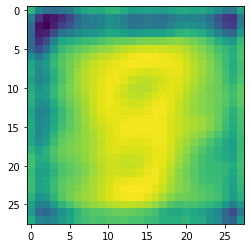

In [20]:
plt.imshow(model.sample(n=2)[1].numpy().squeeze())